## L98-59 Modelling

This notebook will contain the analysis of the L98-59 system. This project utilises data from HARPS and ESPRESSO, the analysis will be done using the RadVel package. 

### Get the data

##### HARPS data

$\bold{\text{Program IDs:}}$ 198.C-0838, 1102.C-0339, and 0102.C-0525

$\bold{\text{Observation Dates:}}$ Between October 17, 2018 (BJD = 2458408.5) and April 28, 2019 (BJD = 2458601.5)

##### ESPRESSO data

$\bold{\text{Program IDs:}}$  1102.C-0744, 1102.C-0958, and 1104.C-0350

$\bold{\text{Observation Dates:}}$ Between November 14, 2018 (BJD = 2458436.5), and March 4, 2020
(BJD = 2458912.5)


##### Data Access
https://archive.eso.org/cms.html


In [77]:
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

### HARPS Data
Unpack the SCIENCE.SPECTRUM data

In [83]:
# Open the .fits file (SCIENCE.SPECTRUM)
science_spectrum_file = '../dataset/HARPS/ADP.2019-05-24T01:50:46.106.fits'
hdul = fits.open(science_spectrum_file)

# Display information about the .fits file
hdul.info()

# Inspect the headers of the first data extension
header = hdul[1].header
print("######################")
print(repr(header))

# List the column names and their data types
spectrum_data = hdul[1].data
print("######################")
print(spectrum_data.columns)

# Extract specific columns
wavelength = spectrum_data['WAVE'][0]  # or the corresponding column name for time
flux = spectrum_data['FLUX'][0]
error = spectrum_data['ERR'][0]

Filename: ../dataset/HARPS/ADP.2019-05-24T01:50:46.106.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    3072   ()      
  1  SPECTRUM      1 BinTableHDU     46   1R x 3C   [313089D, 313089E, 313089E]   
######################
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              5009424 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVE    '                                                     

/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


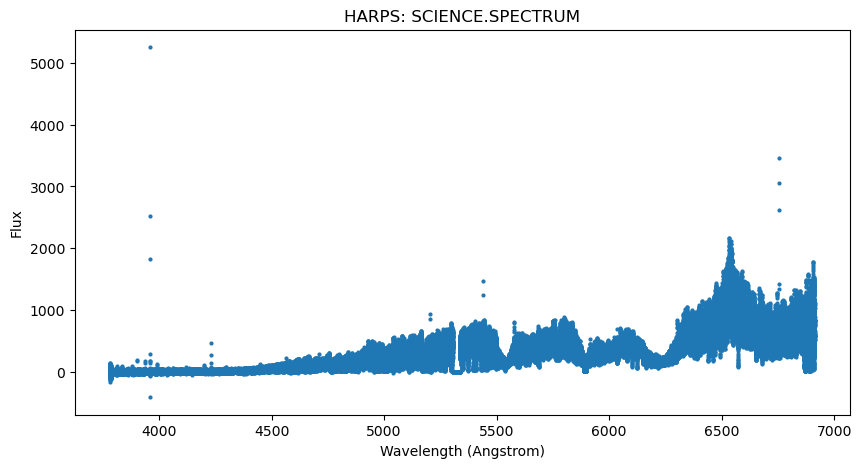

In [84]:
# Plot HARP SPECTRUM

plt.figure(figsize=(10, 5))
plt.errorbar(wavelength, flux, yerr=error, fmt='o', markersize=2, capsize=3)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.title('HARPS: SCIENCE.SPECTRUM')
plt.show()

Unpack the CCF data

Could not fit Gaussian for observation 22
Could not fit Gaussian for observation 23
Could not fit Gaussian for observation 24
Could not fit Gaussian for observation 26
Could not fit Gaussian for observation 27
Could not fit Gaussian for observation 28
Could not fit Gaussian for observation 31
Could not fit Gaussian for observation 34
Could not fit Gaussian for observation 37
Could not fit Gaussian for observation 42
Could not fit Gaussian for observation 44
Could not fit Gaussian for observation 46
Could not fit Gaussian for observation 48
Could not fit Gaussian for observation 49
Could not fit Gaussian for observation 50
Could not fit Gaussian for observation 54
Could not fit Gaussian for observation 60
Could not fit Gaussian for observation 70
            Time            RV      RV_Error
0   58544.050161  1.782659e-09  2.425470e-11
1   58544.050161  1.782659e-09  2.425470e-11
2   58544.050161  1.782659e-09  2.425470e-11
3   58544.050161  1.782659e-09  2.425470e-11
4   58544.050161  1

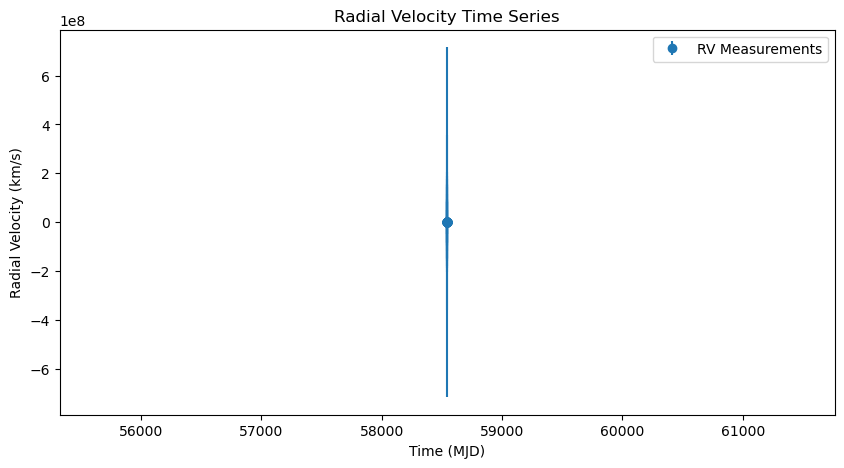

In [103]:
# ccf file path
ccf_files = ['../dataset/HARPS/data/reduced/2019-03-01/HARPS.2019-03-02T01:12:13.931_ccf_M2_A.fits']

# Define a Gaussian function for fitting
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

# initialise lists
rv_measurements = []
rv_errors = []
observation_times = []

# Loop over each CCF file to extract data
for ccf_file in ccf_files:
    # Open the CCF .fits file
    hdul = fits.open(ccf_file)

    # Extract the header and data
    primary_header = hdul[0].header
    data = hdul[0].data.T  # Transpose to get (RV_steps, Observations)

    # Generate the RV array
    crval1 = primary_header['CRVAL1']  # Reference value for the first pixel
    cdelt1 = primary_header['CDELT1']  # Increment per pixel
    naxis1 = primary_header['NAXIS1']  # Number of pixels

    rv = crval1 + cdelt1 * np.arange(naxis1)

    # Extract observation time from the primary header
    observation_time = primary_header.get('MJD-OBS', 'Unknown')

    # Process each observation in the data (each column corresponds to an observation)
    for observation_index in range(data.shape[1]):
        ccf = data[:, observation_index]

        # Fit the CCF with a Gaussian
        try:
            popt, pcov = curve_fit(gaussian, rv, ccf, p0=[1, 0, 1])
            rv_fit = popt[1]
            rv_error = np.sqrt(np.diag(pcov))[1]

            # Store the RV and its error
            rv_measurements.append(rv_fit)
            rv_errors.append(rv_error)

            # Store the observation time (MJD for numerical consistency)
            observation_times.append(observation_time)

        except RuntimeError:
            print(f"Could not fit Gaussian for observation {observation_index}")

    # Close the FITS file
    hdul.close()

# Compile the RV time series into a DataFrame
rv_data = pd.DataFrame({
    'Time': observation_times,
    'RV': rv_measurements,
    'RV_Error': rv_errors
})

# Convert observation times to a numerical format if necessary (e.g., Julian Date)
# Assuming 'Time' is already in a suitable format for analysis
print(rv_data)

# Plot RV measurements vs. time
plt.figure(figsize=(10, 5))
plt.errorbar(rv_data['Time'], rv_data['RV'], yerr=rv_data['RV_Error'], fmt='o', label='RV Measurements')
plt.xlabel('Time (MJD)')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity Time Series')
plt.legend()
plt.show()

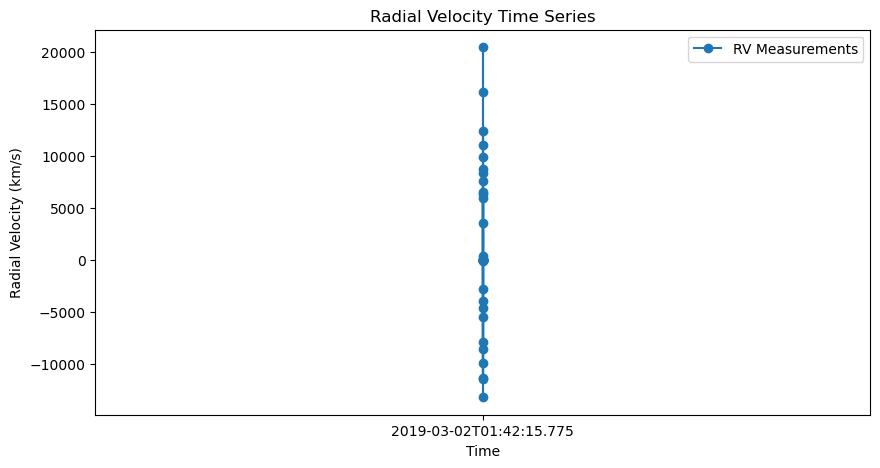

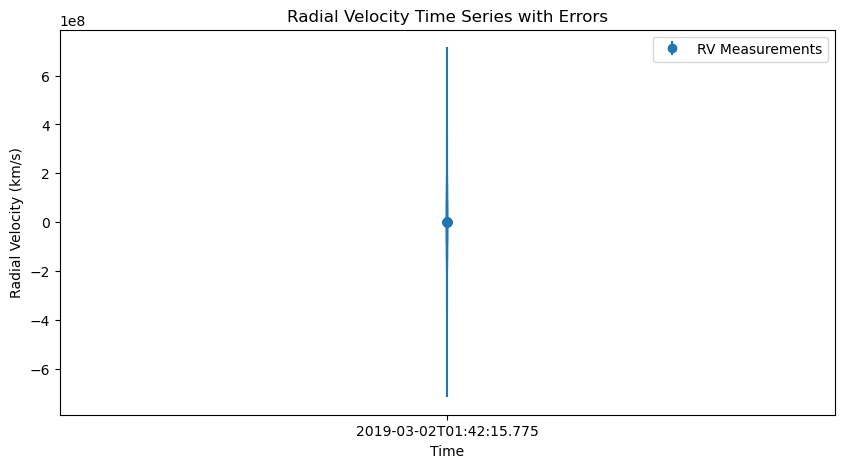

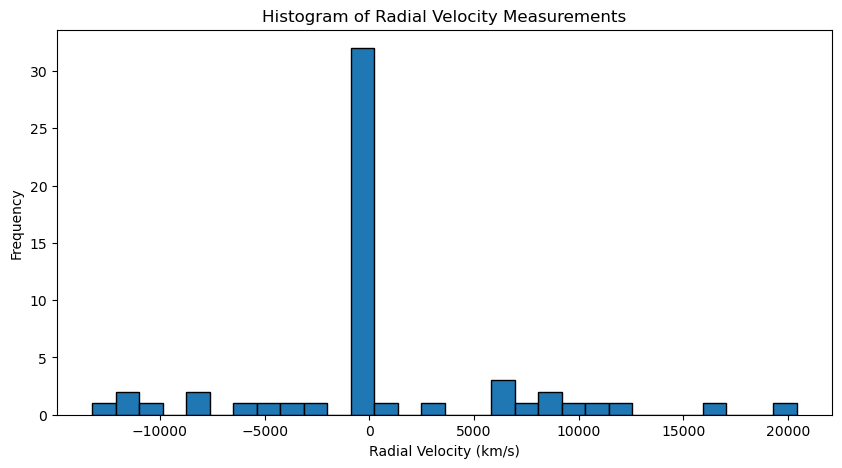

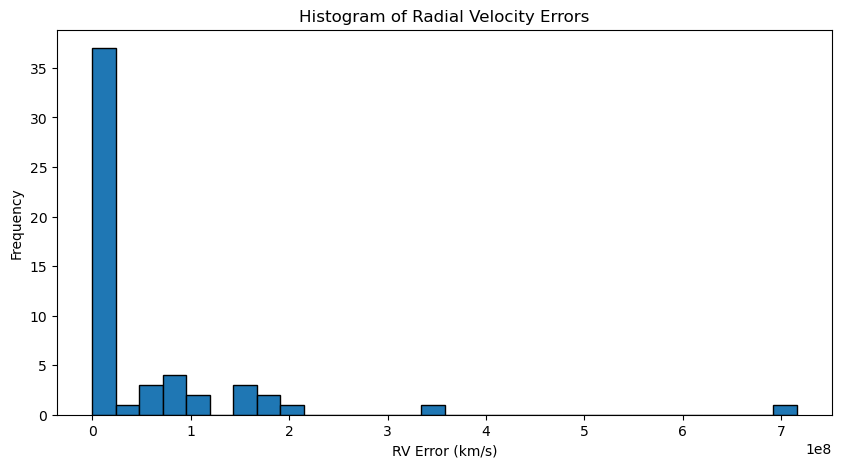

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rv_data is your DataFrame with 'Time', 'RV', and 'RV_Error' columns

# Plot RV measurements vs. time
plt.figure(figsize=(10, 5))
plt.plot(rv_data['Time'], rv_data['RV'], 'o-', label='RV Measurements')
plt.xlabel('Time')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity Time Series')
plt.legend()
plt.show()

# Plot RV measurements with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(rv_data['Time'], rv_data['RV'], yerr=rv_data['RV_Error'], fmt='o', label='RV Measurements')
plt.xlabel('Time')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity Time Series with Errors')
plt.legend()
plt.show()

# Plot histogram of RV values
plt.figure(figsize=(10, 5))
plt.hist(rv_data['RV'], bins=30, edgecolor='black')
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Velocity Measurements')
plt.show()

# Plot histogram of RV errors
plt.figure(figsize=(10, 5))
plt.hist(rv_data['RV_Error'], bins=30, edgecolor='black')
plt.xlabel('RV Error (km/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Velocity Errors')
plt.show()


In [102]:
# Path to the CCF file
ccf_file = '../dataset/HARPS/data/reduced/2019-03-01/HARPS.2019-03-02T01:12:13.931_ccf_M2_A.fits'

# Open the CCF .fits file
hdul = fits.open(ccf_file)

# Extract the header
header = hdul[0].header

# Extract the data
data = hdul[0].data

# Generate the RV array
crval1 = header['CRVAL1']  # Reference value for the first pixel
cdelt1 = header['CDELT1']  # Increment per pixel
naxis1 = header['NAXIS1']  # Number of pixels
date_obs = header['MJD-OBS']

rv = crval1 + cdelt1 * np.arange(naxis1)

# Print the first few values of the generated RV array
print("Generated RV Array:", rv)

print("Date of Observation:", date_obs)

print(crval1)
print(cdelt1)
print(naxis1)

Generated RV Array: [-18.88 -18.63 -18.38 -18.13 -17.88 -17.63 -17.38 -17.13 -16.88 -16.63
 -16.38 -16.13 -15.88 -15.63 -15.38 -15.13 -14.88 -14.63 -14.38 -14.13
 -13.88 -13.63 -13.38 -13.13 -12.88 -12.63 -12.38 -12.13 -11.88 -11.63
 -11.38 -11.13 -10.88 -10.63 -10.38 -10.13  -9.88  -9.63  -9.38  -9.13
  -8.88  -8.63  -8.38  -8.13  -7.88  -7.63  -7.38  -7.13  -6.88  -6.63
  -6.38  -6.13  -5.88  -5.63  -5.38  -5.13  -4.88  -4.63  -4.38  -4.13
  -3.88  -3.63  -3.38  -3.13  -2.88  -2.63  -2.38  -2.13  -1.88  -1.63
  -1.38  -1.13  -0.88  -0.63  -0.38  -0.13   0.12   0.37   0.62   0.87
   1.12   1.37   1.62   1.87   2.12   2.37   2.62   2.87   3.12   3.37
   3.62   3.87   4.12   4.37   4.62   4.87   5.12   5.37   5.62   5.87
   6.12   6.37   6.62   6.87   7.12   7.37   7.62   7.87   8.12   8.37
   8.62   8.87   9.12   9.37   9.62   9.87  10.12  10.37  10.62  10.87
  11.12  11.37  11.62  11.87  12.12  12.37  12.62  12.87  13.12  13.37
  13.62  13.87  14.12  14.37  14.62  14.87  15.12  15.37 

In [107]:
# Path to the CCF file
ccf_file = '../dataset/HARPS/data/reduced/2019-03-01/HARPS.2019-03-02T01:12:13.931_ccf_M2_B.fits'

# Open the CCF .fits file
hdul = fits.open(ccf_file)

# Extract the header
header = hdul[0].header

# Extract the data
data = hdul[0].data

# Generate the RV array
crval1 = header['CRVAL1']  # Reference value for the first pixel
cdelt1 = header['CDELT1']  # Increment per pixel
naxis1 = header['NAXIS1']  # Number of pixels
date_obs = header['MJD-OBS']

rv = crval1 + cdelt1 * np.arange(naxis1)

# Print the first few values of the generated RV array
print("Generated RV Array:", rv)

print("Date of Observation:", date_obs)

print(crval1)
print(cdelt1)
print(naxis1)

Generated RV Array: [-18.88 -18.63 -18.38 -18.13 -17.88 -17.63 -17.38 -17.13 -16.88 -16.63
 -16.38 -16.13 -15.88 -15.63 -15.38 -15.13 -14.88 -14.63 -14.38 -14.13
 -13.88 -13.63 -13.38 -13.13 -12.88 -12.63 -12.38 -12.13 -11.88 -11.63
 -11.38 -11.13 -10.88 -10.63 -10.38 -10.13  -9.88  -9.63  -9.38  -9.13
  -8.88  -8.63  -8.38  -8.13  -7.88  -7.63  -7.38  -7.13  -6.88  -6.63
  -6.38  -6.13  -5.88  -5.63  -5.38  -5.13  -4.88  -4.63  -4.38  -4.13
  -3.88  -3.63  -3.38  -3.13  -2.88  -2.63  -2.38  -2.13  -1.88  -1.63
  -1.38  -1.13  -0.88  -0.63  -0.38  -0.13   0.12   0.37   0.62   0.87
   1.12   1.37   1.62   1.87   2.12   2.37   2.62   2.87   3.12   3.37
   3.62   3.87   4.12   4.37   4.62   4.87   5.12   5.37   5.62   5.87
   6.12   6.37   6.62   6.87   7.12   7.37   7.62   7.87   8.12   8.37
   8.62   8.87   9.12   9.37   9.62   9.87  10.12  10.37  10.62  10.87
  11.12  11.37  11.62  11.87  12.12  12.37  12.62  12.87  13.12  13.37
  13.62  13.87  14.12  14.37  14.62  14.87  15.12  15.37 